In [26]:
import sys
import numpy as np
import scipy.stats
import operator
import itertools
import math

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

from scipy.stats import ttest_ind

import multiprocessing

"""
import random

random.seed(int(sys.argv[1]))
np.random.seed(int(sys.argv[1]))
"""

np.seterr(divide='ignore')

#def runGA():
# Generate the distributions to be used in the GP optimization process

# Index by: [sample number (0-29)]
sig_diff_samples_0v10 = np.random.normal(loc=0, scale=3, size=(30, 500))
sig_diff_samples_10v0 = np.random.normal(loc=10, scale=5, size=(30, 500))

sig_diff_samples_0v10_same_std = np.random.normal(loc=0, scale=3, size=(30, 500))
sig_diff_samples_10v0_same_std = np.random.normal(loc=100, scale=3, size=(30, 500))

sig_diff_samples_0v100 = np.random.normal(loc=0, scale=3, size=(30, 500))
sig_diff_samples_100v0 = np.random.normal(loc=100, scale=5, size=(30, 500))

sig_diff_samples_0v100_same_std = np.random.normal(loc=0, scale=30, size=(30, 500))
sig_diff_samples_100v0_same_std = np.random.normal(loc=100, scale=30, size=(30, 500))

sig_diff_samples_0v1000 = np.random.normal(loc=0, scale=3, size=(30, 500))
sig_diff_samples_1000v0 = np.random.normal(loc=1000, scale=5, size=(30, 500))

sig_diff_samples_0v1000_same_std = np.random.normal(loc=0, scale=300, size=(30, 500))
sig_diff_samples_1000v0_same_std = np.random.normal(loc=1000, scale=300, size=(30, 500))

# Index by: [group (0/1)][sample number (0-29)]
both_dist = np.append(sig_diff_samples_0v10.reshape(
                          sig_diff_samples_0v10.shape[0] * sig_diff_samples_0v10.shape[1]),
                      sig_diff_samples_10v0.reshape(
                          sig_diff_samples_10v0.shape[0] * sig_diff_samples_10v0.shape[1]))
both_dist_mean = np.mean(both_dist)
both_dist_sd = np.std(both_dist)
permuted_samples_0v10 = np.random.normal(loc=both_dist_mean, scale=both_dist_sd, size=(2, 30, 500))
null_samples_0v10 = np.random.normal(loc=both_dist_mean, scale=both_dist_sd, size=(2, 30, 500))

both_dist = np.append(sig_diff_samples_0v10_same_std.reshape(
                          sig_diff_samples_0v10_same_std.shape[0] * sig_diff_samples_0v10_same_std.shape[1]),
                      sig_diff_samples_10v0_same_std.reshape(
                          sig_diff_samples_10v0_same_std.shape[0] * sig_diff_samples_10v0_same_std.shape[1]))
both_dist_mean = np.mean(both_dist)
both_dist_sd = np.std(both_dist)
permuted_samples_0v10_same_std = np.random.normal(loc=both_dist_mean, scale=both_dist_sd, size=(2, 30, 500))
null_samples_0v10_same_std = np.random.normal(loc=both_dist_mean, scale=both_dist_sd, size=(2, 30, 500))

both_dist = np.append(sig_diff_samples_0v100.reshape(
                          sig_diff_samples_0v100.shape[0] * sig_diff_samples_0v100.shape[1]),
                      sig_diff_samples_100v0.reshape(
                          sig_diff_samples_100v0.shape[0] * sig_diff_samples_100v0.shape[1]))
both_dist_mean = np.mean(both_dist)
both_dist_sd = np.std(both_dist)
permuted_samples_0v100 = np.random.normal(loc=both_dist_mean, scale=both_dist_sd, size=(2, 30, 500))
null_samples_0v100 = np.random.normal(loc=both_dist_mean, scale=both_dist_sd, size=(2, 30, 500))

both_dist = np.append(sig_diff_samples_0v100_same_std.reshape(
                          sig_diff_samples_0v100_same_std.shape[0] * sig_diff_samples_0v100_same_std.shape[1]),
                      sig_diff_samples_100v0_same_std.reshape(
                          sig_diff_samples_100v0_same_std.shape[0] * sig_diff_samples_100v0_same_std.shape[1]))
both_dist_mean = np.mean(both_dist)
both_dist_sd = np.std(both_dist)
permuted_samples_0v100_same_std = np.random.normal(loc=both_dist_mean, scale=both_dist_sd, size=(2, 30, 500))
null_samples_0v100_same_std = np.random.normal(loc=both_dist_mean, scale=both_dist_sd, size=(2, 30, 500))

both_dist = np.append(sig_diff_samples_0v1000.reshape(
                          sig_diff_samples_0v1000.shape[0] * sig_diff_samples_0v1000.shape[1]),
                      sig_diff_samples_1000v0.reshape(
                          sig_diff_samples_1000v0.shape[0] * sig_diff_samples_1000v0.shape[1]))
both_dist_mean = np.mean(both_dist)
both_dist_sd = np.std(both_dist)
permuted_samples_0v1000 = np.random.normal(loc=both_dist_mean, scale=both_dist_sd, size=(2, 30, 500))
null_samples_0v1000 = np.random.normal(loc=both_dist_mean, scale=both_dist_sd, size=(2, 30, 500))

both_dist = np.append(sig_diff_samples_0v1000_same_std.reshape(
                          sig_diff_samples_0v1000_same_std.shape[0] * sig_diff_samples_0v1000_same_std.shape[1]),
                      sig_diff_samples_1000v0_same_std.reshape(
                          sig_diff_samples_1000v0_same_std.shape[0] * sig_diff_samples_1000v0_same_std.shape[1]))
both_dist_mean = np.mean(both_dist)
both_dist_sd = np.std(both_dist)
permuted_samples_0v1000_same_std = np.random.normal(loc=both_dist_mean, scale=both_dist_sd, size=(2, 30, 500))
null_samples_0v1000_same_std = np.random.normal(loc=both_dist_mean, scale=both_dist_sd, size=(2, 30, 500))

ttest_vals = []

# Sig diff sample comparisons
for sample1, sample2 in zip(sig_diff_samples_0v10, sig_diff_samples_10v0):
    ttest_vals.append(ttest_ind(sample1, sample2).statistic)
    ttest_vals.append(ttest_ind(sample2, sample1).statistic)

for sample1, sample2 in zip(sig_diff_samples_0v100, sig_diff_samples_100v0):
    ttest_vals.append(ttest_ind(sample1, sample2).statistic)
    ttest_vals.append(ttest_ind(sample2, sample1).statistic)

for sample1, sample2 in zip(sig_diff_samples_0v1000, sig_diff_samples_1000v0):
    ttest_vals.append(ttest_ind(sample1, sample2).statistic)
    ttest_vals.append(ttest_ind(sample2, sample1).statistic)

for sample1, sample2 in zip(sig_diff_samples_0v10_same_std, sig_diff_samples_10v0_same_std):
    ttest_vals.append(ttest_ind(sample1, sample2).statistic)
    ttest_vals.append(ttest_ind(sample2, sample1).statistic)

for sample1, sample2 in zip(sig_diff_samples_0v100_same_std, sig_diff_samples_100v0_same_std):
    ttest_vals.append(ttest_ind(sample1, sample2).statistic)
    ttest_vals.append(ttest_ind(sample2, sample1).statistic)

for sample1, sample2 in zip(sig_diff_samples_0v1000_same_std, sig_diff_samples_1000v0_same_std):
    ttest_vals.append(ttest_ind(sample1, sample2).statistic)
    ttest_vals.append(ttest_ind(sample2, sample1).statistic)

# Null sample comparisons
for sample1, sample2 in zip(null_samples_0v10[0], null_samples_0v10[1]):
    ttest_vals.append(ttest_ind(sample1, sample2).statistic)

for sample1, sample2 in zip(null_samples_0v100[0], null_samples_0v100[1]):
    ttest_vals.append(ttest_ind(sample1, sample2).statistic)

for sample1, sample2 in zip(null_samples_0v1000[0], null_samples_0v1000[1]):
    ttest_vals.append(ttest_ind(sample1, sample2).statistic)

for sample1, sample2 in zip(null_samples_0v10_same_std[0], null_samples_0v10_same_std[1]):
    ttest_vals.append(ttest_ind(sample1, sample2).statistic)

for sample1, sample2 in zip(null_samples_0v100_same_std[0], null_samples_0v100_same_std[1]):
    ttest_vals.append(ttest_ind(sample1, sample2).statistic)

for sample1, sample2 in zip(null_samples_0v1000_same_std[0], null_samples_0v1000_same_std[1]):
    ttest_vals.append(ttest_ind(sample1, sample2).statistic)

# Permuted sample comparisons
for sample1, sample2 in zip(permuted_samples_0v10[0], permuted_samples_0v10[1]):
    ttest_vals.append(ttest_ind(sample1, sample2).statistic)

for sample1, sample2 in zip(permuted_samples_0v100[0], permuted_samples_0v100[1]):
    ttest_vals.append(ttest_ind(sample1, sample2).statistic)

for sample1, sample2 in zip(permuted_samples_0v1000[0], permuted_samples_0v1000[1]):
    ttest_vals.append(ttest_ind(sample1, sample2).statistic)

for sample1, sample2 in zip(permuted_samples_0v10_same_std[0], permuted_samples_0v10_same_std[1]):
    ttest_vals.append(ttest_ind(sample1, sample2).statistic)

for sample1, sample2 in zip(permuted_samples_0v100_same_std[0], permuted_samples_0v100_same_std[1]):
    ttest_vals.append(ttest_ind(sample1, sample2).statistic)

for sample1, sample2 in zip(permuted_samples_0v1000_same_std[0], permuted_samples_0v1000_same_std[1]):
    ttest_vals.append(ttest_ind(sample1, sample2).statistic)

ttest_vals = np.array(ttest_vals)

# GP tree: takes two arrays as input, returns a test staistic
pset = gp.PrimitiveSetTyped('MAIN', [np.ndarray, np.ndarray], float)
pset.renameArguments(ARG0='x1')
pset.renameArguments(ARG1='x2')

# Logical operators on the distance array
#pset.addPrimitive(np.logical_and, [np.ndarray, np.ndarray], np.ndarray, name='array_and')
#pset.addPrimitive(np.logical_or, [np.ndarray, np.ndarray], np.ndarray, name='array_or')
#pset.addPrimitive(np.logical_xor, [np.ndarray, np.ndarray], np.ndarray, name='array_xor')
#pset.addPrimitive(np.logical_not, [np.ndarray], np.ndarray, name='array_not')

# Mathematical operators on the distance array
#pset.addPrimitive(np.add, [np.ndarray, np.ndarray], np.ndarray, name='array_add')
#pset.addPrimitive(np.subtract, [np.ndarray, np.ndarray], np.ndarray, name='array_sub')
#pset.addPrimitive(np.multiply, [np.ndarray, np.ndarray], np.ndarray, name='array_mul')
#pset.addPrimitive(np.divide, [np.ndarray, np.ndarray], np.ndarray, name='array_div')
pset.addPrimitive(np.sqrt, [np.ndarray], np.ndarray, name='array_sqrt')
pset.addPrimitive(np.square, [np.ndarray], np.ndarray, name='array_square')
pset.addPrimitive(np.abs, [np.ndarray], np.ndarray, name='array_abs')

# Statistics derived from the distance array
pset.addPrimitive(np.mean, [np.ndarray], float, name='array_mean')
pset.addPrimitive(np.median, [np.ndarray], float, name='array_median')
pset.addPrimitive(np.min, [np.ndarray], float, name='array_min')
pset.addPrimitive(np.max, [np.ndarray], float, name='array_max')
pset.addPrimitive(np.std, [np.ndarray], float, name='array_std')
pset.addPrimitive(np.var, [np.ndarray], float, name='array_var')
pset.addPrimitive(np.size, [np.ndarray], float, name='array_size')
pset.addPrimitive(np.sum, [np.ndarray], float, name='array_sum')
pset.addPrimitive(scipy.stats.sem, [np.ndarray], float, name='array_stderr')

# Mathematical operators with single values
def protected_div(left, right):
    try:
        return float(left) / float(right)
    except ZeroDivisionError:
        return 1.

pset.addPrimitive(operator.add, [float, float], float, name='float_add')
pset.addPrimitive(operator.sub, [float, float], float, name='float_sub')
pset.addPrimitive(operator.mul, [float, float], float, name='float_mul')
pset.addPrimitive(protected_div, [float, float], float, name='float_div')
pset.addPrimitive(np.sqrt, [float], float, name='float_sqrt')
pset.addPrimitive(np.square, [float], float, name='float_square')
pset.addPrimitive(np.abs, [float], float, name='float_abs')

# Mathematical operators on the distance array with a single value
pset.addPrimitive(np.add, [np.ndarray, float], np.ndarray, name='array_add_float')
pset.addPrimitive(np.subtract, [np.ndarray, float], np.ndarray, name='array_sub_float')
pset.addPrimitive(np.multiply, [np.ndarray, float], np.ndarray, name='array_mul_float')
pset.addPrimitive(np.divide, [np.ndarray, float], np.ndarray, name='array_div_float')

# Equivalence operators on the distance array with a single value
#pset.addPrimitive(np.less, [np.ndarray, float], np.ndarray, name='array_less_than_float')
#pset.addPrimitive(np.equal, [np.ndarray, float], np.ndarray, name='array_equal_float')

# Terminals
pset.addTerminal(1.0, float)
#pset.addEphemeralConstant('rand{}'.format(np.random.randint(1e9)), lambda: np.random.random() * 100., float)
#pset.addTerminal(np.multiply(np.random.random(size=features.shape[0]), 100.), np.ndarray)
#pset.addTerminal(np.array([True] * features.shape[0]), np.ndarray)
#pset.addTerminal(np.array([False] * features.shape[0]), np.ndarray)

creator.create('FitnessMulti', base.Fitness, weights=(-1., -1.))
creator.create('Individual', gp.PrimitiveTree, fitness=creator.FitnessMulti)

toolbox = base.Toolbox()
toolbox.register('expr', gp.genHalfAndHalf, pset=pset, min_=1, max_=4)

"""
def return_ttest():
    return creator.Individual.from_string('float_div(float_sub(array_mean(x1), array_mean(x2)), float_add(array_stderr(x1), array_stderr(x2)))', pset)
    #return creator.Individual.from_string('float_div(float_sub(array_mean(x1), array_mean(x2)), float_sqrt(float_add(float_div(array_var(x1), array_size(x1)), float_div(array_var(x2), array_size(x2)))))', pset)

toolbox.register('individual', return_ttest)
"""
toolbox.register('individual', tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register('population', tools.initRepeat, list, toolbox.individual)
toolbox.register('compile', gp.compile, pset=pset)

pool = multiprocessing.Pool()
toolbox.register('map', pool.map)

def evaluate_individual(individual):
    # If the solution contains a constant value in it, throw it out
    str_ind = str(individual)
    if '1.0' in str_ind:
        return sys.maxsize, sys.maxsize
    
    func = toolbox.compile(expr=individual)

    gp_ttest_vals = []
    
    # Sig diff sample comparisons
    for sample1, sample2 in zip(sig_diff_samples_0v10, sig_diff_samples_10v0):
        gp_ttest_vals.append(func(sample1, sample2))
        gp_ttest_vals.append(func(sample2, sample1))

    for sample1, sample2 in zip(sig_diff_samples_0v100, sig_diff_samples_100v0):
        gp_ttest_vals.append(func(sample1, sample2))
        gp_ttest_vals.append(func(sample2, sample1))

    for sample1, sample2 in zip(sig_diff_samples_0v1000, sig_diff_samples_1000v0):
        gp_ttest_vals.append(func(sample1, sample2))
        gp_ttest_vals.append(func(sample2, sample1))
    
    for sample1, sample2 in zip(sig_diff_samples_0v10_same_std, sig_diff_samples_10v0_same_std):
        gp_ttest_vals.append(func(sample1, sample2))
        gp_ttest_vals.append(func(sample2, sample1))

    for sample1, sample2 in zip(sig_diff_samples_0v100_same_std, sig_diff_samples_100v0_same_std):
        gp_ttest_vals.append(func(sample1, sample2))
        gp_ttest_vals.append(func(sample2, sample1))

    for sample1, sample2 in zip(sig_diff_samples_0v1000_same_std, sig_diff_samples_1000v0_same_std):
        gp_ttest_vals.append(func(sample1, sample2))
        gp_ttest_vals.append(func(sample2, sample1))

    # Null sample comparisons
    for sample1, sample2 in zip(null_samples_0v10[0], null_samples_0v10[1]):
        gp_ttest_vals.append(func(sample1, sample2))
        
    for sample1, sample2 in zip(null_samples_0v100[0], null_samples_0v100[1]):
        gp_ttest_vals.append(func(sample1, sample2))
        
    for sample1, sample2 in zip(null_samples_0v1000[0], null_samples_0v1000[1]):
        gp_ttest_vals.append(func(sample1, sample2))

    for sample1, sample2 in zip(null_samples_0v10_same_std[0], null_samples_0v10_same_std[1]):
        gp_ttest_vals.append(func(sample1, sample2))

    for sample1, sample2 in zip(null_samples_0v100_same_std[0], null_samples_0v100_same_std[1]):
        gp_ttest_vals.append(func(sample1, sample2))
        
    for sample1, sample2 in zip(null_samples_0v1000_same_std[0], null_samples_0v1000_same_std[1]):
        gp_ttest_vals.append(func(sample1, sample2))
    
    # Permuted sample comparisons
    for sample1, sample2 in zip(permuted_samples_0v10[0], permuted_samples_0v10[1]):
        gp_ttest_vals.append(func(sample1, sample2))
        
    for sample1, sample2 in zip(permuted_samples_0v100[0], permuted_samples_0v100[1]):
        gp_ttest_vals.append(func(sample1, sample2))
        
    for sample1, sample2 in zip(permuted_samples_0v1000[0], permuted_samples_0v1000[1]):
        gp_ttest_vals.append(func(sample1, sample2))
    
    for sample1, sample2 in zip(permuted_samples_0v10_same_std[0], permuted_samples_0v10_same_std[1]):
        gp_ttest_vals.append(func(sample1, sample2))
    
    for sample1, sample2 in zip(permuted_samples_0v100_same_std[0], permuted_samples_0v100_same_std[1]):
        gp_ttest_vals.append(func(sample1, sample2))
        
    for sample1, sample2 in zip(permuted_samples_0v1000_same_std[0], permuted_samples_0v1000_same_std[1]):
        gp_ttest_vals.append(func(sample1, sample2))
        
    gp_ttest_vals = np.array(gp_ttest_vals)
        
    # If the solution produces NaN or inf values, throw it out
    if np.any(np.isnan(gp_ttest_vals)) or np.any(np.isinf(gp_ttest_vals)):
        return sys.maxsize, len(individual)

    # Third fitness component is the size (i.e., complexity) of the GP tree
    ind_complexity = np.sum([type(component) == gp.Primitive for component in individual])
    
    return (
        np.sum(np.abs(np.subtract(gp_ttest_vals, ttest_vals))),
        ind_complexity
           )

toolbox.register('evaluate', evaluate_individual)
toolbox.register('select', tools.selNSGA2)
toolbox.register('mate', gp.cxOnePoint)
toolbox.register('expr_mut', gp.genFull, min_=0, max_=3)
toolbox.register('mutate', gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

def pareto_eq(ind1, ind2):
    """Determines whether two individuals are equal on the Pareto front
    Parameters
    ----------
    ind1: DEAP individual from the GP population
        First individual to compare
    ind2: DEAP individual from the GP population
        Second individual to compare
    Returns
    ----------
    individuals_equal: bool
        Boolean indicating whether the two individuals are equal on
        the Pareto front
    """
    return np.allclose(ind1.fitness.values, ind2.fitness.values)

pop = toolbox.population(n=500)
pareto_front = tools.ParetoFront(similar=pareto_eq)
stats = tools.Statistics(lambda ind: ind.fitness.values[0])
stats.register('avg', np.mean)
stats.register('std', np.std)
stats.register('min', np.min)
stats.register('max', np.max)

t_test = creator.Individual.from_string('float_div(float_sub(array_mean(x1), array_mean(x2)), float_sqrt(float_add(float_div(array_var(x1), array_size(x1)), float_div(array_var(x2), array_size(x2)))))', pset)
print('t-test fitness: {}'.format(evaluate_individual(t_test)))

t_test = creator.Individual.from_string('float_div(float_sub(array_mean(x1), array_mean(x2)), float_add(array_stderr(x1), array_stderr(x2)))', pset)
print('t-test fitness: {}'.format(evaluate_individual(t_test)))

algorithms.eaMuPlusLambda(population=pop, toolbox=toolbox,
                          cxpb=0.5, mutpb=0.5, mu=500, lambda_=1000,
                          ngen=250, stats=stats, halloffame=pareto_front)

print('')
for index, ind in enumerate(pareto_front):
    print(index, ind.fitness, ind)

<string>:1: RuntimeWarning: invalid value encountered in sqrt
<string>:1: RuntimeWarning: invalid value encountered in sqrt
<string>:1: RuntimeWarning: invalid value encountered in sqrt


t-test fitness: (292.42698424113246, 12)
t-test fitness: (79867.800949149387, 7)


<string>:1: RuntimeWarning: invalid value encountered in sqrt
<string>:1: RuntimeWarning: invalid value encountered in sqrt
/Users/randal_olson/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:3569: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)
<string>:1: RuntimeWarning: invalid value encountered in sqrt
<string>:1: RuntimeWarning: invalid value encountered in sqrt
<string>:1: RuntimeWarning: invalid value encountered in sqrt
/Users/randal_olson/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:3569: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)
/Users/randal_olson/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:3569: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


gen	nevals	avg        	std        	min   	max        
0  	500   	5.90296e+18	4.42722e+18	291488	9.22337e+18


/Users/randal_olson/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:3569: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)
/Users/randal_olson/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:3569: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)
/Users/randal_olson/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:3569: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)
/Users/randal_olson/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:3569: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


1  	1000  	8.66999e+17	2.69164e+18	215858	9.22337e+18


/Users/randal_olson/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:3569: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


2  	1000  	1.90542e+06	7.59606e+06	215858	4.12076e+07
3  	1000  	349696     	50065.9    	182088	430370     
4  	1000  	316154     	32037.8    	180928	351279     
5  	1000  	292337     	14682.3    	180928	295082     
6  	1000  	293763     	11584.6    	180928	295054     
7  	1000  	291481     	19585.5    	180928	295054     
8  	1000  	288285     	26743.9    	180928	295054     
9  	1000  	283492     	34269.6    	180928	295054     
10 	1000  	270141     	47010.1    	171617	295054     
11 	1000  	245127     	56533.9    	171617	295054     
12 	1000  	200562     	43045.6    	171617	295054     
13 	1000  	181654     	8684.05    	171617	295054     
14 	1000  	181654     	8684.05    	171617	295054     
15 	1000  	181654     	8684.05    	171617	295054     
16 	1000  	181654     	8684.05    	171617	295054     
17 	1000  	181654     	8684.05    	171617	295054     
18 	1000  	181615     	8730.84    	161437	295054     
19 	1000  	181576     	8777.21    	161437	295054     
20 	1000  	181498     	8868.

array_min(array_div_float(array_sub_float(array_square(x1), array_mean(x2)), array_stderr(array_square(x1))))



''

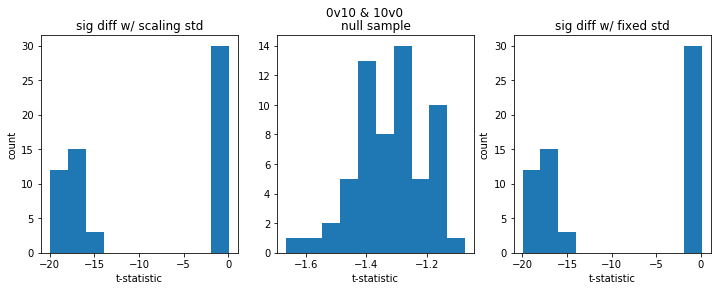

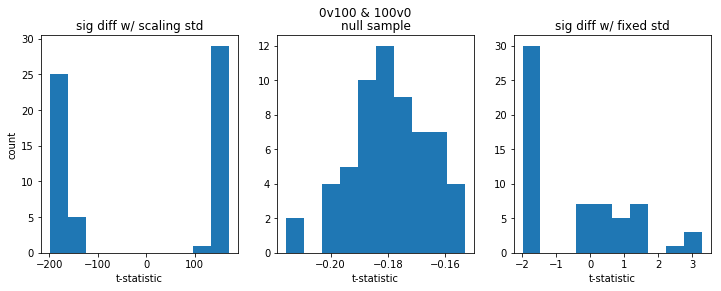

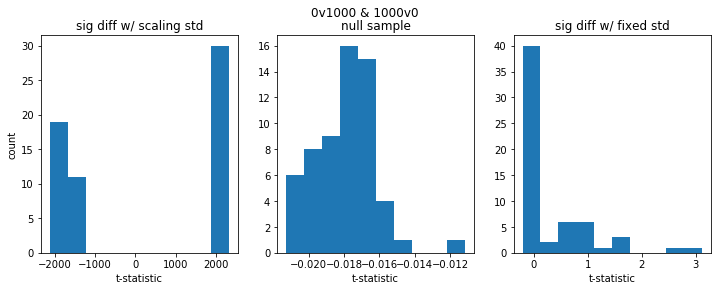

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind

pareto_index = 0

print(pareto_front[pareto_index])
print('')
func = toolbox.compile(expr=pareto_front[pareto_index])

### 0v10 ###

plt.figure(figsize=(12, 4))
plt.suptitle('0v10 & 10v0')

t_vals = []
for sample1, sample2 in zip(sig_diff_samples_0v10, sig_diff_samples_10v0):
    t_vals.append(func(sample1, sample2))
    t_vals.append(func(sample2, sample1))

plt.subplot(1, 3, 1)
plt.title('sig diff w/ scaling std')
plt.xlabel('t-statistic')
plt.ylabel('count')
plt.hist(t_vals, label='sig diff w/ scaling std')

t_vals = []
for sample1, sample2 in zip(null_samples_0v10[0], null_samples_0v10[1]):
    t_vals.append(func(sample1, sample2))
    t_vals.append(func(sample2, sample1))
plt.subplot(1, 3, 2)
plt.title('null sample')
plt.xlabel('t-statistic')
plt.hist(t_vals, label='null sample')

t_vals = []
for sample1, sample2 in zip(sig_diff_samples_0v10, sig_diff_samples_10v0):
    t_vals.append(func(sample1, sample2))
    t_vals.append(func(sample2, sample1))

plt.subplot(1, 3, 3)
plt.title('sig diff w/ fixed std')
plt.xlabel('t-statistic')
plt.ylabel('count')
plt.hist(t_vals, label='sig diff w/ fixed std')

### 0v100 ###

plt.figure(figsize=(12, 4))
plt.suptitle('0v100 & 100v0')

t_vals = []
for sample1, sample2 in zip(sig_diff_samples_0v100, sig_diff_samples_100v0):
    t_vals.append(func(sample1, sample2))
    t_vals.append(func(sample2, sample1))

plt.subplot(1, 3, 1)
plt.title('sig diff w/ scaling std')
plt.xlabel('t-statistic')
plt.ylabel('count')
plt.hist(t_vals, label='sig diff w/ scaling std')

t_vals = []
for sample1, sample2 in zip(null_samples_0v100[0], null_samples_0v100[1]):
    t_vals.append(func(sample1, sample2))
    t_vals.append(func(sample2, sample1))

plt.subplot(1, 3, 2)
plt.title('null sample')
plt.xlabel('t-statistic')
plt.hist(t_vals, label='null sample')

t_vals = []
for sample1, sample2 in zip(sig_diff_samples_0v100_same_std, sig_diff_samples_100v0_same_std):
    t_vals.append(func(sample1, sample2))
    t_vals.append(func(sample2, sample1))

plt.subplot(1, 3, 3)
plt.title('sig diff w/ fixed std')
plt.xlabel('t-statistic')
plt.hist(t_vals, label='sig diff w/ fixed std')

### 0v1000 ###

plt.figure(figsize=(12, 4))
plt.suptitle('0v1000 & 1000v0')

t_vals = []
for sample1, sample2 in zip(sig_diff_samples_0v1000, sig_diff_samples_1000v0):
    t_vals.append(func(sample1, sample2))
    t_vals.append(func(sample2, sample1))

plt.subplot(1, 3, 1)
plt.title('sig diff w/ scaling std')
plt.xlabel('t-statistic')
plt.ylabel('count')
plt.hist(t_vals, label='sig diff w/ scaling std')

t_vals = []
for sample1, sample2 in zip(null_samples_0v1000[0], null_samples_0v1000[1]):
    t_vals.append(func(sample1, sample2))
    t_vals.append(func(sample2, sample1))

plt.subplot(1, 3, 2)
plt.title('null sample')
plt.xlabel('t-statistic')
plt.hist(t_vals, label='null sample')

t_vals = []
for sample1, sample2 in zip(sig_diff_samples_0v1000_same_std, sig_diff_samples_1000v0_same_std):
    t_vals.append(func(sample1, sample2))
    t_vals.append(func(sample2, sample1))

plt.subplot(1, 3, 3)
plt.title('sig diff w/ fixed std')
plt.xlabel('t-statistic')
plt.hist(t_vals, label='sig diff w/ fixed std')
;

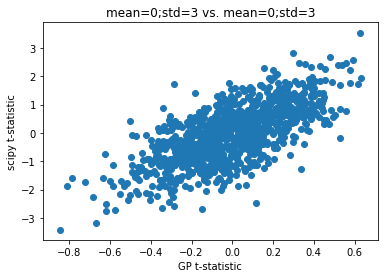

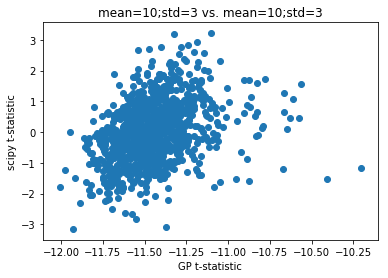

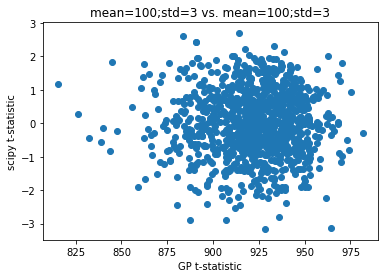

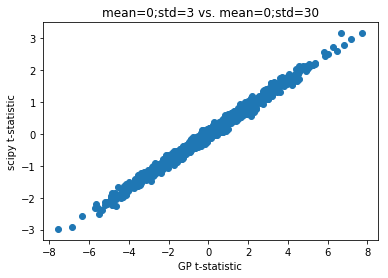

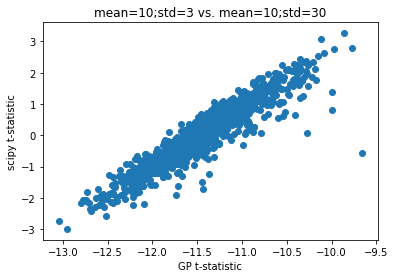

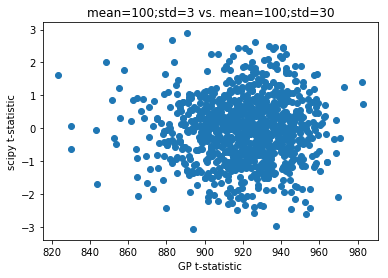

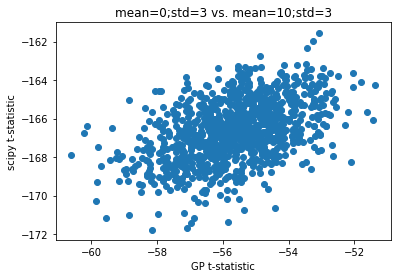

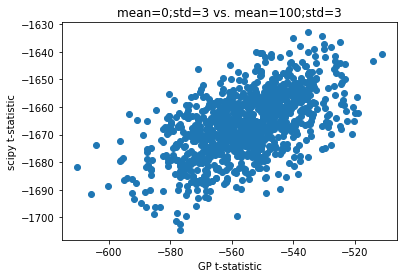

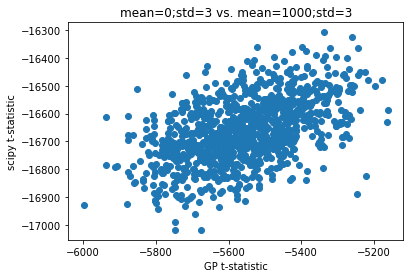

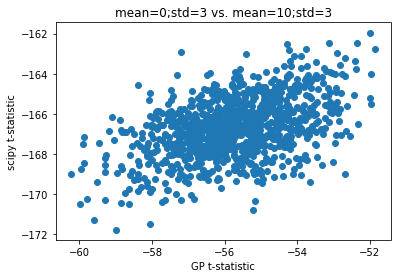

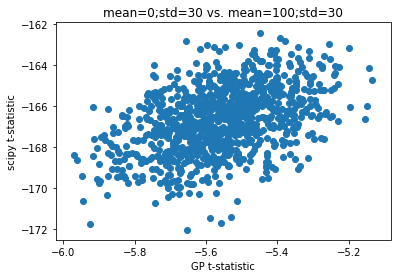

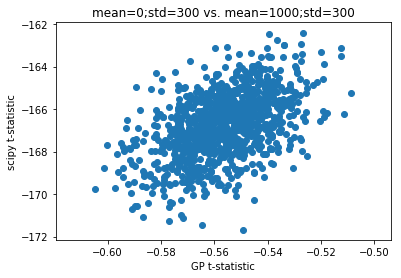

In [15]:
def plot_test_dist(stat_func, loc1, loc2, std1=3, std2=3):
    stat_dist = []
    ttest_dist = []
    for rep in range(1000):
        dist1 = np.random.normal(loc=loc1, scale=std1, size=5000)
        dist2 = np.random.normal(loc=loc2, scale=std2, size=5000)
        stat_dist.append(stat_func(dist1, dist2))
        ttest_dist.append(ttest_ind(dist1, dist2).statistic)
    plt.figure()
    plt.title('mean={};std={} vs. mean={};std={}'.format(loc1, std1, loc2, std2))
    plt.scatter(stat_dist, ttest_dist)
    plt.xlabel('GP t-statistic')
    plt.ylabel('scipy t-statistic')

# Same mean, same std
plot_test_dist(func, 0, 0)
plot_test_dist(func, 10, 10)
plot_test_dist(func, 100, 100)

# Same mean, diff std
plot_test_dist(func, 0, 0, std1=3, std2=30)
plot_test_dist(func, 10, 10, std1=3, std2=30)
plot_test_dist(func, 100, 100, std1=3, std2=30)

# Diff mean, same std
plot_test_dist(func, 0, 10)
plot_test_dist(func, 0, 100)
plot_test_dist(func, 0, 1000)

# Diff mean, diff std
plot_test_dist(func, 0, 10)
plot_test_dist(func, 0, 100, std1=30, std2=30)
plot_test_dist(func, 0, 1000, std1=300, std2=300)

# Evolutionary path to the t-test

In [16]:
for ttest_str in ['float_div(float_sub(array_mean(x1), array_mean(x2)), float_sqrt(float_add(float_div(array_var(x1), array_size(x1)), float_div(array_var(x2), array_size(x2)))))',
                  'float_div(float_sub(array_mean(x1), array_mean(x2)), float_sqrt(float_div(float_add(array_var(x1), array_var(x2)), array_size(x1))))',
                  'float_div(float_sub(array_mean(x1), array_mean(x2)), float_sqrt(float_add(array_var(x1), array_var(x2))))',
                  'float_div(float_sub(array_mean(x1), array_mean(x2)), float_div(float_add(array_var(x1), array_var(x2)), array_size(x1)))',
                  'float_div(float_sub(array_mean(x1), array_mean(x2)), float_sqrt(float_add(array_var(x1), array_var(x2))))',
                  'float_div(float_sub(array_mean(x1), array_mean(x2)), float_add(array_var(x1), array_var(x2)))',
                  'float_div(float_sub(array_mean(x1), array_mean(x2)), float_div(array_var(x1), array_size(x1)))',
                  'float_div(float_sub(array_mean(x1), array_mean(x2)), float_add(array_std(x1), array_std(x2)))',
                  'float_div(float_sub(array_mean(x1), array_mean(x2)), array_var(x1))',
                  'float_div(float_sub(array_mean(x1), array_mean(x2)), array_std(x1))',
                  'float_sub(array_mean(x1), array_mean(x2))']:
    t_test = creator.Individual.from_string(ttest_str, pset)
    print('{}: {}'.format(evaluate_individual(t_test), ttest_str))

print('')

for ttest_str in ['float_div(float_sub(array_mean(x1), array_mean(x2)), float_add(array_stderr(x1), array_stderr(x2)))',
                  'float_div(float_sub(array_mean(x1), array_mean(x2)), array_stderr(x1))',
                  'float_div(float_sub(array_mean(x1), array_mean(x2)), array_stderr(x2))',]:
    t_test = creator.Individual.from_string(ttest_str, pset)
    print('{}: {}'.format(evaluate_individual(t_test), ttest_str))

(295.27072385392654, 12): float_div(float_sub(array_mean(x1), array_mean(x2)), float_sqrt(float_add(float_div(array_var(x1), array_size(x1)), float_div(array_var(x2), array_size(x2)))))
(295.27072385392319, 10): float_div(float_sub(array_mean(x1), array_mean(x2)), float_sqrt(float_div(float_add(array_var(x1), array_var(x2)), array_size(x1))))
(281629.44142912986, 8): float_div(float_sub(array_mean(x1), array_mean(x2)), float_sqrt(float_add(array_var(x1), array_var(x2))))
(874779.06540556054, 9): float_div(float_sub(array_mean(x1), array_mean(x2)), float_div(float_add(array_var(x1), array_var(x2)), array_size(x1)))
(281629.44142912986, 8): float_div(float_sub(array_mean(x1), array_mean(x2)), float_sqrt(float_add(array_var(x1), array_var(x2))))
(292507.31229407847, 7): float_div(float_sub(array_mean(x1), array_mean(x2)), float_add(array_var(x1), array_var(x2)))
(2569564.9632146345, 7): float_div(float_sub(array_mean(x1), array_mean(x2)), float_div(array_var(x1), array_size(x1)))
(285255.